# CardiCat 学習 - event_5158.csv

CardiCat_ICLR25.ipynb の構造に基づいた学習ノートブック

## 1. ライブラリのインポート

In [1]:
import os
import sys
from datetime import datetime
from time import process_time
import json
import pickle
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from cycler import cycler
import joblib
import glob
from types import SimpleNamespace

import tensorflow as tf

# CardiCatパス設定
LIB_PATH = "/home/ubuntu/CardiCat/"
sys.path.insert(1, LIB_PATH)

from src import network as network
from src import postprocessing as postprocessing
from src import preprocessing as preprocessing
from src import reporting as reporting
from src import vae_model as vae

print(f"TensorFlow バージョン: {tf.__version__}")
print(f"GPU 利用可能: {tf.config.list_physical_devices('GPU')}")

2025-12-30 23:51:58.205703: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-12-30 23:51:58.216963: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1767106318.231069 2176263 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1767106318.234818 2176263 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2025-12-30 23:51:58.249149: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instr

TensorFlow バージョン: 2.18.1
GPU 利用可能: [PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


## 2. パラメータ設定

In [2]:
# モデル設定
model = "CardiCat"  # 選択肢: CardiCat, VAE, eVAE
dataset = "event_5158"
run_id = "test_run"

# パラメータ辞書
param_dict = {
    "embed_th": 3,           # エンベディング閾値
    "epochs": 50,            # エポック数（テスト用に削減）
    "batch_size": 512,       # バッチサイズ
    "learn_rate": 0.0005,    # 学習率
    "latent_dim": 15,        # 潜在次元数
    "mixed_loss": False,
    "weighted_loss": True,
    "recon_factor": 5,       # 再構成損失の重み
    "kl_factor": 1,          # KLダイバージェンスの重み
    "emb_regularization": True,
    "emb_reg_factor": 1,
    "hot_factor": 1.0,
    "emb_factor": 1.0,
    "num_factor": 1.0,
    "show_figs": True,
    "save_figs": False,
    "save_files": True,
    "train_ratio": 0.8,
    "val_ratio": 0.2,
    "lib_path": LIB_PATH,
    "data_path": "/home/ubuntu/CardiCat/eventid_content/concat/train/", # データセットパス
    "output_path": "output/",
    "comment": "event_5158_test",
    "cVAE": False,
    "cVAE_mask": False,
    "attention": False,
    "resampling": False,
    "onehot_ind_cat": False,
}

# モデルタイプに応じた設定
if model == "VAE":
    param_dict["embed_th"] = 5000
    param_dict["emb_loss"] = False
elif model == "eVAE":
    param_dict["emb_loss"] = False
elif model == "CardiCat":
    param_dict["emb_loss"] = True

# モデル設定
param_dict["model"] = model
param_dict["dataset_log_name"] = dataset

# ログ用コピー
logs = param_dict.copy()
logs["model"] = model
logs["dataset_log_name"] = dataset
logs["run_id"] = run_id
logs["date_time"] = datetime.now().strftime("%Y%m%d_%H%M")

print(f"モデル: {model}")
print(f"データセット: {dataset}")

モデル: CardiCat
データセット: event_5158


## 3. データの読み込み

In [3]:
# CSVファイル読み込み
csv_path = os.path.join(param_dict["data_path"], "event_5158.csv")
print(f"読み込み中: {csv_path}")

dataframe_full = pd.read_csv(csv_path, low_memory=False)
print(f"データフレーム形状: {dataframe_full.shape}")
print(f"カラム: {list(dataframe_full.columns)}")

読み込み中: /home/ubuntu/CardiCat/eventid_content/concat/train/event_5158.csv
データフレーム形状: (436592, 11)
カラム: ['EventID', 'Timestamp', 'Label', 'LayerName', 'Protocol', 'FilterRTID', 'LayerRTID', 'SourcePort', 'Application', 'ProcessId', 'SourceAddress']


In [4]:
# 学習に使用しないカラムを除外
DROP_COLUMNS = ["EventID", "Timestamp", "Label", "SourcePort", "ProcessId"]
existing_drop_cols = [col for col in DROP_COLUMNS if col in dataframe_full.columns]
dataframe = dataframe_full.drop(columns=existing_drop_cols)

# カーディナリティが1以下のカラムを除外
low_card_cols = [col for col in dataframe.columns if dataframe[col].nunique() <= 1]
print(f"低カーディナリティカラムを除外: {low_card_cols}")
dataframe = dataframe.drop(columns=low_card_cols)

print(f"学習用データフレーム形状: {dataframe.shape}")
print(f"除外したカラム: {existing_drop_cols + low_card_cols}")

# ターゲットカラムなし
param_dict["is_target"] = False

低カーディナリティカラムを除外: ['LayerName']
学習用データフレーム形状: (436592, 5)
除外したカラム: ['EventID', 'Timestamp', 'Label', 'SourcePort', 'ProcessId', 'LayerName']


In [5]:
# 訓練/テスト分割（評価用に元データを保持）
dataframe_shuffled = dataframe.sample(frac=1, random_state=42).reset_index(drop=True)
split_idx = int(param_dict["train_ratio"] * len(dataframe_shuffled))

dataframe_train = dataframe_shuffled.iloc[:split_idx].copy()
dataframe_test = dataframe_shuffled.iloc[split_idx:].copy()

print(f"訓練データサイズ: {dataframe_train.shape}")
print(f"テストデータサイズ: {dataframe_test.shape}")

訓練データサイズ: (349273, 5)
テストデータサイズ: (87319, 5)


In [6]:
# カーディナリティ確認
preprocessing.get_df_cardinality(dataframe_train)

,index,cardinality,type
0,Application,60.0,object
1,SourceAddress,5.0,object
2,Protocol,NaN,int64
3,FilterRTID,NaN,int64
4,LayerRTID,NaN,int64


## 4. 前処理

In [7]:
# カラムタイプの検出
catCols, intCols, floatCols = preprocessing.get_col_types(
    dataframe_train, is_y=param_dict["is_target"], verbose=True
)

# 
col_tokens_all_tmp = {}
for i in catCols:
    col_tokens_all_tmp[i] = len(dataframe_train[i].unique())

if param_dict["cVAE"]:
    tmpEmb = [
        key
        for key, value in col_tokens_all_tmp.items()
        if value >= param_dict["embed_th"]
    ]
else:
    tmpEmb = []

print(f"\nカテゴリカラム: {catCols}")
print(f"整数カラム: {intCols}")
print(f"浮動小数点カラム: {floatCols}")

Columns Types: 
 {'Protocol': dtype('int64'), 'FilterRTID': dtype('int64'), 'LayerRTID': dtype('int64'), 'Application': dtype('O'), 'SourceAddress': dtype('O')}


Categorical Columns:  ['Application', 'SourceAddress']


Int Columns:  ['Protocol', 'FilterRTID', 'LayerRTID']


Float Columns:  []



カテゴリカラム: ['Application', 'SourceAddress']
整数カラム: ['Protocol', 'FilterRTID', 'LayerRTID']
浮動小数点カラム: []


In [8]:
# 周辺確率の計算
catMarginals = preprocessing.get_catMarginals(dataframe_train, catCols)
print(f"カテゴリカル周辺分布を {len(catMarginals)} カラムで計算")

カテゴリカル周辺分布を 2 カラムで計算


Conditional VAE or MASK logic:

In [9]:
if param_dict["cVAE"]:
    # marg_sample = lambda e: np.random.choice(
    #     list(catMarginals[e].keys()), p=list(catMarginals[e].values())
    #
    alpha = 1  # (if <= alpha then x, else marg sample)

    if param_dict["cVAE_mask"]:
        for col in tmpEmb:
            dataframe_train["cond_" + col] = "mask"
        for index, row in dataframe_train.iterrows():
            # print(index,row)
            col_sampled = np.random.choice(tmpEmb)
            # df.loc[index, "cond_" + col_sampled] = preprocessing.marg_sample(
            #     col_sampled, catMarginals
            # )

            # df.loc[index, "cond_" + col_sampled] = df.loc[index, col_sampled]
            dataframe_train.loc[index, "cond_" + col_sampled] = (
                dataframe_train.loc[index, col_sampled]
                if np.random.rand() <= alpha
                else preprocessing.marg_sample(col_sampled, catMarginals)
            )
    else:
        for col in tmpEmb:
            dataframe_train["cond_" + col] = dataframe_train[col].apply(
                lambda x: x
                if np.random.rand() <= alpha
                else preprocessing.marg_sample(col, catMarginals)
            )  # df[col].copy()
dataframe_train.head()

,Protocol,FilterRTID,LayerRTID,Application,SourceAddress
0,17,0,38,\device\harddiskvolume3\windows\system32\svcho...,::
1,17,0,36,\device\harddiskvolume3\windows\system32\svcho...,::
2,6,0,36,\device\harddiskvolume3\windows\system32\svcho...,::
3,17,0,36,\device\harddiskvolume3\windows\system32\svcho...,::
4,6,0,36,\device\harddiskvolume3\windows\system32\lsass...,0.0.0.0


In [10]:
# ラベルエンコーディング（重要なステップ！）
df_encoded, label_encoder = preprocessing.labelEncoding(
    dataframe_train.copy(),
    catCols,
)

print(f"エンコード後データフレーム形状: {df_encoded.shape}")
print(f"ラベルエンコーダ作成対象: {list(label_encoder.keys())}")

エンコード後データフレーム形状: (349273, 5)
ラベルエンコーダ作成対象: ['Application', 'SourceAddress']


In [11]:
# TensorFlowデータセットの作成
train, test = np.split(
        df_encoded.sample(frac=1), [int(param_dict["val_ratio"] * len(df_encoded))]
    )
print("Total length: {:,}".format(len(df_encoded)))
print(
    "length of train: {:,} which is {:.1%}".format(
        len(train), param_dict["train_ratio"]
    )
)
print(
    "length of test: {:,} which is {:.1%}".format(
        len(test), 1 - param_dict["train_ratio"]
    )
)
train_ds = preprocessing.df_to_dset(
    train, is_y=param_dict["is_target"], batch_size=param_dict["batch_size"]
)
test_ds = preprocessing.df_to_dset(
    test, is_y=param_dict["is_target"], batch_size=param_dict["batch_size"]
)
train_ds.element_spec

print("訓練データセット作成完了")
print(f"要素仕様: {train_ds.element_spec}")

Total length: 349,273
length of train: 69,854 which is 80.0%
length of test: 279,419 which is 20.0%
訓練データセット作成完了
要素仕様: {'Protocol': TensorSpec(shape=(None,), dtype=tf.int64, name=None), 'FilterRTID': TensorSpec(shape=(None,), dtype=tf.int64, name=None), 'LayerRTID': TensorSpec(shape=(None,), dtype=tf.int64, name=None), 'Application': TensorSpec(shape=(None,), dtype=tf.int64, name=None), 'SourceAddress': TensorSpec(shape=(None,), dtype=tf.int64, name=None)}


I0000 00:00:1767106325.012591 2176263 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 78753 MB memory:  -> device: 0, name: NVIDIA H100 80GB HBM3, pci bus id: 0000:00:04.0, compute capability: 9.0


## 5. データエンコーダの作成

In [12]:
# データエンコーダ作成
data_encoder = preprocessing.data_encoder(
    original_df=dataframe_train,
    train_ds=train_ds,
    param_dict=param_dict
)

print(f"カテゴリカラム: {data_encoder.catCols}")
print(f"カテゴリトークン数: {data_encoder.col_tokens_all}")
print(f"総カーディナリティ: {sum(data_encoder.col_tokens_all.values()):,}")
print(f"エンベディングサイズ: {data_encoder.emb_sizes_all}")
print(f"埋め込みカラム: {data_encoder.embCols}")
print(f"One-Hotカラム: {data_encoder.ohCols}")

2025-12-30 23:52:07.048188: I tensorflow/core/framework/local_rendezvous.cc:405] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
2025-12-30 23:52:07.269515: I tensorflow/core/framework/local_rendezvous.cc:405] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


[<KerasTensor shape=(None, 4), dtype=float32, sparse=False, ragged=False, name=keras_tensor_3>, <KerasTensor shape=(None, 3), dtype=float32, sparse=False, ragged=False, name=keras_tensor_5>]
カテゴリカラム: ['Application', 'SourceAddress']
カテゴリトークン数: {'Application': 60, 'SourceAddress': 5}
総カーディナリティ: 65
エンベディングサイズ: {'Application': 4, 'SourceAddress': 3}
埋め込みカラム: {'Application': 4, 'SourceAddress': 3}
One-Hotカラム: {}


## 6. ネットワーク構築

In [13]:
# エンコーディングレイヤーの取得
(
    all_inputs,
    all_features,
    all_inputs_1hot,
    all_features_1hot,
    condInputs,
    condFeatures,
    numFeatures,
    numLookup,
    all_features_cod,
) = data_encoder.get_encoding_layers()

# data_encoderに保存（後で使用）
data_encoder.all_inputs = all_inputs
data_encoder.all_features = all_features
data_encoder.all_inputs_1hot = all_inputs_1hot
data_encoder.all_features_1hot = all_features_1hot
data_encoder.condInputs = condInputs
data_encoder.condFeatures = condFeatures
data_encoder.numFeatures = numFeatures
data_encoder.numLookup = numLookup
data_encoder.all_features_cod = all_features_cod

print(f"入力レイヤー数: {len(all_inputs)}")
print("エンコーディングレイヤー構築成功")

2025-12-30 23:52:07.810161: I tensorflow/core/framework/local_rendezvous.cc:405] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


[<KerasTensor shape=(None, 4), dtype=float32, sparse=False, ragged=False, name=keras_tensor_19>, <KerasTensor shape=(None, 3), dtype=float32, sparse=False, ragged=False, name=keras_tensor_21>]
入力レイヤー数: 5
エンコーディングレイヤー構築成功


In [14]:
# オプティマイザ
optimizer = tf.keras.optimizers.Adam(learning_rate=param_dict["learn_rate"])

# サンプリングレイヤー
final = vae.sampling(param_dict["latent_dim"], param_dict["latent_dim"])
input_decoder = param_dict["latent_dim"]

# エンコーダ構築
dec_inputs = tf.keras.Input(shape=(input_decoder,), name="dec_latent_input")
enc = network.encoder(
    data_encoder.all_inputs, 
    data_encoder.all_features, 
    param_dict["latent_dim"]
)

# デコーダ構築
dec = network.decoder(dec_inputs, dec_inputs, data_encoder.layer_sizes)

# コーデックス構築（エンベディング損失用）
if param_dict["emb_loss"]:
    cod = vae.codex(data_encoder.all_inputs, data_encoder.all_features_cod)
else:
    cod = vae.codex(data_encoder.all_inputs_1hot, data_encoder.all_features_1hot)

print("ネットワーク構築成功")

ネットワーク構築成功


In [15]:
# エンコーダのサマリー
enc.summary()

Model: "Encoder"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ Application         │ (None, 1)         │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ SourceAddress       │ (None, 1)         │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ emb_Application     │ (None, 1, 4)      │        240 │ Application[0][0] │
│ (Embedding)         │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ emb_SourceAddress   │ (None, 1, 3)      │         15 │ SourceAddress[0]… │
│ (Embedding)         │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ Protocol            │ (None, 1)         │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ FilterRTID          │ (None, 1)         │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ LayerRTID           │ (None, 1)         │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ embed_reshape_Appl… │ (None, 4)         │          0 │ emb_Application[… │
│ (Reshape)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ embed_reshape_Sour… │ (None, 3)         │          0 │ emb_SourceAddres… │
│ (Reshape)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ Protocol_norm       │ (None, 1)         │          3 │ Protocol[0][0]    │
│ (Normalization)     │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ FilterRTID_norm     │ (None, 1)         │          3 │ FilterRTID[0][0]  │
│ (Normalization)     │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ LayerRTID_norm      │ (None, 1)         │          3 │ LayerRTID[0][0]   │
│ (Normalization)     │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate_3       │ (None, 10)        │          0 │ embed_reshape_Ap… │
│ (Concatenate)       │                   │            │ embed_reshape_So… │
│                     │                   │            │ Protocol_norm[0]… │
│                     │                   │            │ FilterRTID_norm[… │
│                     │                   │            │ LayerRTID_norm[0… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense (Dense)       │ (None, 128)       │      1,408 │ concatenate_3[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_1 (Dense)     │ (None, 128)       │     16,512 │ dense[0][0]       │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_2 (Dense)     │ (None, 128)       │     16,512 │ dense_1[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ mean (Dense)        │ (None, 15)        │      1,935 │ dense_2[0][0]   

 Total params: 38,566 (150.66 KB)

 Trainable params: 38,557 (150.61 KB)

 Non-trainable params: 9 (48.00 B)

In [16]:
# Uncomment only if your system supports graphviz
#
# Save network architecture plots:
if param_dict["save_figs"]:
    tf.keras.utils.plot_model(
        enc,
        show_shapes=True,
        rankdir="LR",
        to_file=os.path.join(
            param_dict["lib_path"],
            "output/model_architecture_graphs/{}_{}_encoder.png".format(
                logs["date_time"], logs["dataset_log_name"]
            ),
        ),
        show_layer_activations=True,
    )

    tf.keras.utils.plot_model(
        dec,
        show_shapes=True,
        rankdir="LR",
        to_file=os.path.join(
            param_dict["lib_path"],
            "output/model_architecture_graphs/{}_{}_decoder.png".format(
                logs["date_time"], logs["dataset_log_name"]
            ),
        ),
        show_layer_activations=True,
    )

    tf.keras.utils.plot_model(
        cod,
        show_shapes=True,
        rankdir="LR",
        to_file=os.path.join(
            param_dict["lib_path"],
            "output/model_architecture_graphs/{}_{}_codex.png".format(
                logs["date_time"], logs["dataset_log_name"]
            ),
        ),
    )

In [17]:
tf.keras.utils.plot_model(
    enc,
    show_shapes=True,
    rankdir="LR",
    show_layer_activations=True,
    show_trainable=True,
)

You must install graphviz (see instructions at https://graphviz.gitlab.io/download/) for `plot_model` to work.


In [18]:
# 学習可能パラメータ数の取得
trainableParamsEnc = np.sum([np.prod(v.shape) for v in enc.trainable_weights])
trainableParamsDec = np.sum([np.prod(v.shape) for v in dec.trainable_weights])

print(f"エンコーダ学習可能パラメータ: {int(trainableParamsEnc):,}")
print(f"デコーダ学習可能パラメータ: {int(trainableParamsDec):,}")
print(f"VAE総パラメータ: {int(trainableParamsEnc + trainableParamsDec):,}")

logs["trainable_params"] = f"{int(trainableParamsEnc + trainableParamsDec):,}"

エンコーダ学習可能パラメータ: 38,557
デコーダ学習可能パラメータ: 36,362
VAE総パラメータ: 74,919


## 7. 学習

In [19]:
# エンベディング重みの初期分散を取得
emb_weights = {}
for layer in enc.layers:
    if layer.name.startswith("emb_") and hasattr(layer, "trainable_weights") and layer.trainable_weights:
        emb_weights[layer.name] = layer.trainable_weights[0].numpy()

emb_init_var = [
    tf.math.reduce_mean(tf.math.reduce_variance(emb_weights[emb], axis=0))
    for emb in emb_weights.keys()
] if emb_weights else []

# cVAE用（今回は未使用）
# tmpEmb = []

In [20]:
# 学習実行！
print(f"\n### {model} の学習開始 ###")
CardiCat_start = process_time()

tf.config.run_functions_eagerly(True)

output_loss, loss_logs_all, emb_weights = vae.train_high_vae(
    train_ds=train_ds,
    enc=enc,
    dec=dec,
    cod=cod,
    final=final,
    optimizer=optimizer,
    layer_sizes=data_encoder.layer_sizes,
    param_dict=param_dict,
    weights=data_encoder.weights,
    emb_init_var=emb_init_var,
    tmpEmb=tmpEmb,
)

CardiCat_stop = process_time()
CardiCat_time = round(CardiCat_stop - CardiCat_start, 2)
print(f"\n学習完了: {CardiCat_time} 秒")
logs["losses"] = round(output_loss.iloc[-1, 1:], 2)


### CardiCat の学習開始 ###

### CardiCat: Training CardiCat ###
Training <          > ←↖↑ 0/50 [0%] in 0s (~0s, 0.0/s) 

Training <∙         > →↘↓ 1/50 [2%] in 26s (~19:50, 0.0/s) Losses: Ttl: 0.84, Rec: 0.51(0.10), KL: 0.33, Emb: 0.00

2025-12-30 23:52:34.895070: I tensorflow/core/framework/local_rendezvous.cc:405] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


Training <●●        > ↘↓↙ 10/50 [20%] in 2:04 (~9:00, 0.1/s) Losses: Ttl: 0.44, Rec: 0.25(0.05), KL: 0.20, Emb: 0.00    

2025-12-30 23:54:13.081649: I tensorflow/core/framework/local_rendezvous.cc:405] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


Training <●●●●●     > ↓↙← 25/50 [50%] in 5:26 (~5:20, 0.1/s) Losses: Ttl: 0.40, Rec: 0.23(0.05), KL: 0.17, Emb: 0.00

2025-12-30 23:57:34.433135: I tensorflow/core/framework/local_rendezvous.cc:405] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


Final Losses: Ttl: 0.35, Rec: 0.21(0.04), KL: 0.14, Emb: 0.00 <●●●●●●●●●●> 50/50 [100%] in 10:30.0 (0.08/s)             

学習完了: 638.0 秒


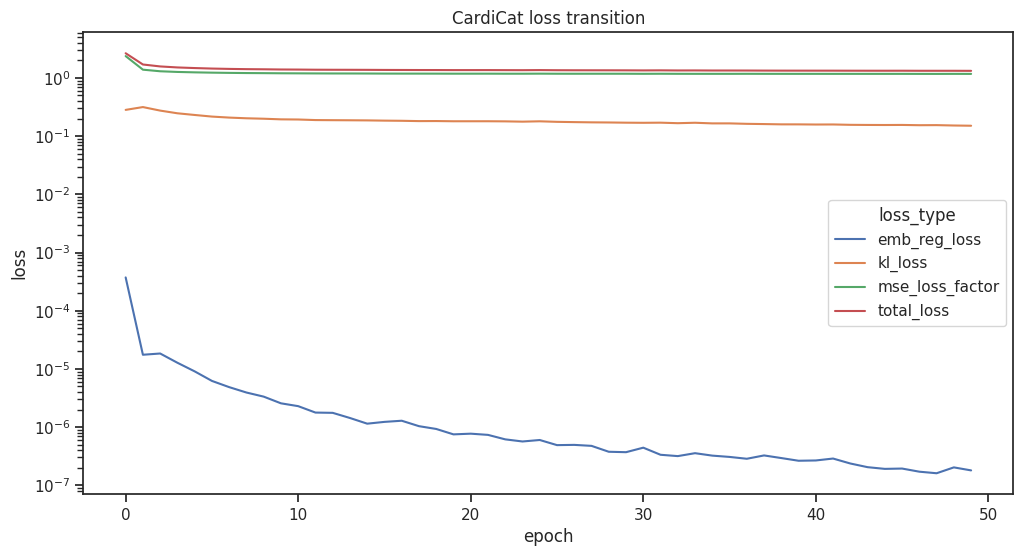

In [21]:
# 損失のプロット
df_melt = output_loss[
    ["epoch", "total_loss", "mse_loss_factor", "kl_loss", "emb_reg_loss"]
].melt(id_vars=["epoch"], var_name="loss_type", value_name="loss")

fig, ax = plt.subplots(figsize=(12, 6))
df_melt.set_index(["loss_type", "epoch"]).unstack("loss_type")["loss"].plot(ax=ax)
ax.set_ylabel("loss")
ax.set_yscale("log")
ax.set_title("CardiCat loss transition")
plt.show()

モデルの保存：

In [22]:
model_dir = os.path.join(LIB_PATH, "output/models", dataset)
os.makedirs(model_dir, exist_ok=True)

# エンコーダとデコーダを保存
enc.save(os.path.join(model_dir, f"encoder.keras"))
dec.save(os.path.join(model_dir, f"decoder.keras"))
cod.save(os.path.join(model_dir, f"codex.keras"))

# ラベルエンコーダを保存（推論時に必要）
with open(os.path.join(model_dir, f"label_encoder.pkl"), "wb") as f:
    pickle.dump(label_encoder, f)

# data_encoderの情報も保存
encoder_info = {
    "catCols": data_encoder.catCols,
    "intCols": data_encoder.intCols,
    "floatCols": data_encoder.floatCols,
    "embCols": data_encoder.embCols,
    "ohCols": data_encoder.ohCols,
    "numCols": data_encoder.numCols,
    "col_tokens_all": data_encoder.col_tokens_all,
    "layer_sizes": data_encoder.layer_sizes,
    "emb_sizes_all": data_encoder.emb_sizes_all,  
    "oh_tokens_all": getattr(data_encoder, 'oh_tokens_all', {}), 
}
with open(os.path.join(model_dir, f"encoder_info.pkl"), "wb") as f:
    pickle.dump(encoder_info, f)

# パラメータも保存
with open(os.path.join(model_dir, f"params.pkl"), "wb") as f:
    pickle.dump(param_dict, f)

print(f"モデル保存完了: {model_dir}")
print(f"保存ファイル:")
for f in os.listdir(model_dir):
    print(f"  - {f}")

モデル保存完了: /home/ubuntu/CardiCat/output/models/event_5158
保存ファイル:
  - decoder.keras
  - label_encoder.pkl
  - params.pkl
  - encoder.keras
  - codex.keras
  - encoder_info.pkl


## 8. 評価

In [23]:
# 1. 読み込むモデルディレクトリを指定 (最新のものを自動取得する場合)
model_dir = os.path.join(LIB_PATH, param_dict["output_path"], "models", "event_5158")

# 2. Keras モデルの読み込み
enc = tf.keras.models.load_model(os.path.join(model_dir, "encoder.keras"))
dec = tf.keras.models.load_model(os.path.join(model_dir, "decoder.keras"))
cod = tf.keras.models.load_model(os.path.join(model_dir, "codex.keras"))

# 3. LabelEncoder の読み込み
label_encoder = joblib.load(os.path.join(model_dir, "label_encoder.pkl"))

# 4. パラメータの読み込みと復元 (param_dict, logs)
saved_params = joblib.load(os.path.join(model_dir, "params.pkl"))
param_dict.update(saved_params)
logs.update(saved_params)

# 5. DataEncoder 情報の復元
de_info = joblib.load(os.path.join(model_dir, "encoder_info.pkl"))
# data_encoder オブジェクトに必要な属性を流し込む
class Dummy:
    pass
data_encoder = Dummy()
for k, v in de_info.items():
    setattr(data_encoder, k, v)
# 特殊なレイヤーはモデルから再取得
data_encoder.all_inputs = enc.inputs
data_encoder.numLookup = [
    layer for layer in enc.layers
    if "Normalization" in layer.__class__.__name__
]
data_encoder.numFeatures = [
    layer.output for layer in data_encoder.numLookup
]

# その他必要な変数の復元
catCols = de_info.get("catCols", [])
numCols = de_info.get("numCols", [])
intCols = de_info.get("intCols", [])
embCols = de_info.get("embCols", [])
emb_sizes = list(de_info.get("emb_sizes_all", {}).values())
oh_tokens = list(de_info.get("oh_tokens_all", {}).values())
col_tokens_all = de_info.get("col_tokens_all", {})

print("モデルと設定の読み込みが正常に完了しました。")

モデルと設定の読み込みが正常に完了しました。


In [24]:
# 訓練セットから合成データを生成
mean, log_var = enc.predict(train_ds)
latents = final([mean, log_var])

df_y_dict = latents

# 予測データの取得
gen_df_train, emb_weights = postprocessing.get_pred(
    enc,
    dec,
    df_y_dict,
    param_dict,
    oh_tokens,
    emb_sizes,
    embCols,
    data_encoder.numFeatures,
    catCols,
    numCols,
    data_encoder.numLookup,
    intCols,
    data_encoder.all_inputs,
    list(col_tokens_all.values()),
    label_encoder,
)

print(f"生成された合成データ形状: {gen_df_train.shape}")
gen_df_train.head()

  1/137 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step

137/137 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step
  32/2183 ━━━━━━━━━━━━━━━━━━━━ 7s 3ms/step

/home/ubuntu/CardiCat/.venv/lib/python3.11/site-packages/tensorflow/python/data/ops/structured_function.py:258: UserWarning: Even though the `tf.config.experimental_run_functions_eagerly` option is set, this option does not apply to tf.data functions. To force eager execution of tf.data functions, please use `tf.data.experimental.enable_debug_mode()`.
  warnings.warn(


2183/2183 ━━━━━━━━━━━━━━━━━━━━ 7s 3ms/step
Finished partitioning Generated Data
Finished Translating 1hot columns to integers
Finished Translating embedded columns to integers
生成された合成データ形状: (69854, 5)


,Application,SourceAddress,Protocol,FilterRTID,LayerRTID
0,\device\harddiskvolume3\windows\system32\svcho...,::,53,-21,36
1,\device\harddiskvolume3\windows\system32\svcho...,0.0.0.0,5,-49,36
2,\device\harddiskvolume3\windows\system32\svcho...,192.168.142.66,5,10,36
3,\device\harddiskvolume3\program files (x86)\am...,0.0.0.0,5,-2,36
4,\device\harddiskvolume3\windows\system32\lsass...,0.0.0.0,5,6,36


In [25]:
# SDVレポート
report = postprocessing.get_report(
    dataframe_test,
    gen_df_train,
    param_dict,
    full=True
)

print("=== 品質レポートサマリー ===")
print(report["summary"])

Creating report: 100%|██████████| 4/4 [00:00<00:00, 25.80it/s]



Overall Quality Score: 71.49%

Properties:
Column Shapes: 70.08%
Column Pair Trends: 72.9%
=== 品質レポートサマリー ===
             Property     Score
0       Column Shapes  0.700787
1  Column Pair Trends  0.729048


In [27]:
# 最終サマリー
summary = {
    "モデル": model,
    "データセット": dataset,
    "学習時間(秒)": CardiCat_time,
    "エポック数": param_dict["epochs"],
    "訓練サンプル数": len(dataframe_train),
    "テストサンプル数": len(dataframe_test),
    "学習可能パラメータ": logs["trainable_params"],
    "総合スコア": round(report["summary"].Score.mean(), 2),
}

print("\n=== 学習サマリー ===")
for k, v in summary.items():
    print(f"  {k}: {v}")


=== 学習サマリー ===
  モデル: CardiCat
  データセット: event_5158
  学習時間(秒): 638.0
  エポック数: 50
  訓練サンプル数: 349273
  テストサンプル数: 87319
  学習可能パラメータ: 74,919
  総合スコア: 0.71


## 9. 潜在表現の取得

---
## 完了